In [1]:
from ngsolve import *

In [2]:
# from netgen.csg import Pnt,SplineCurve2d,CSGeometry,Revolution,Sphere
import numpy as np
import netgen.meshing as ngm
from netgen.csg import *
from netgen.meshing import MeshingStep
from ngsolve.comp import IntegrationRuleSpaceSurface

In [3]:
from es_utils import pos_transformer

In [4]:
from geometry import *

In [5]:
from esfem import WillMoreMDR

In [6]:
from ngsolve.webgui import Draw

In [7]:
from netgen.occ import SplineApproximation, Pnt, Axis, Face, Wire, Segment, Revolve, OCCGeometry, Z, X, Y
#%% Construction of Initial Curved Mesh
dim = 3
order = 2
msize = 0.1
dt = Parameter(0)

In [8]:
from ngsolve import Mesh

In [9]:
def GetRotFace(CurveFunc,msize,T_min=-np.pi/2,T_max=np.pi/2,axis=Z,is_close=False,n=100):
    '''
        Generate Rotational Mesh by revolving a 2d curve (CurveFunc) around an axis (axis)
        CurveFunc: function of phi, return (x(phi), 0, z(phi)) for example
        axis: axis of rotation, default z-axis: curve on x-z plane around z-axis
        is_close: whether the curve is closed (first point = last point)
        n: number of points on the curve
        T_min, T_max: parameter range of the curve
        msize: mesh size
        return: mesh 
    '''
    pnts = [CurveFunc(phi) for phi in np.linspace(T_min,T_max,n)]
    spline = SplineApproximation(pnts, tol=1e-4)
    f = Face(Wire([spline]))
    return f

In [10]:
def BaseTorus(phi,k = 0.4): 
    z = k*np.sin(phi)
    res = Pnt(1+k*np.cos(phi), 0, z)
    return res

* 先生成一个标准的环面

In [11]:
f = GetRotFace(BaseTorus,0.08,T_min=np.pi,
                  T_max=3*np.pi,axis=Z,is_close=True)

In [12]:
f.edges[0].vertices[0].maxh = 0.05

In [13]:
torus = f.Revolve(Axis((0,0,0), Z), 360)
mesh = Mesh(OCCGeometry(torus).GenerateMesh(maxh=msize,
            perfstepsend=ngm.MeshingStep.MESHSURFACE,grading=0.5))

In [14]:
Draw(x,mesh,"vv")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

Perturbed torus
\begin{equation*}
\begin{pmatrix}
(1+\cos\varphi)\cos\theta\\ (1+\cos\varphi)\sin\theta\\
\sin \varphi 
    \end{pmatrix}
    + 
       a \begin{pmatrix}
     \sin 6\theta \cos \varphi \cos \theta \\ 
     \sin 6\theta \cos \varphi \sin \theta  \\ 
     \sin 6\theta \sin \varphi
    \end{pmatrix}
\end{equation*}
在标准的环面的基础上，不同的 $\theta$ 对应的切片的圆的半径不同，是 $1+ a\sin 6\theta$

In [15]:
t = Parameter(0)
r = sqrt(x**2+y**2)
my_theta = atan2(y,x)
a = 0.1
cosmy_phi = (r-1)
sinmy_phi = z
phi = atan2(sinmy_phi,cosmy_phi)
v = CF((a*sin(6*my_theta)*cos(my_theta)*cos(phi),
        a*sin(6*my_theta)*sin(my_theta)*cos(phi),
        a*sin(6*my_theta)*sin(phi)))

* 绘制展示一下速度场的梯度大小

In [16]:
mesh.UnsetDeformation()
Draw(Norm(CF((v.Diff(x),v.Diff(y)))),mesh,"vv")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [17]:
DB_BGN_Obj = WillMoreMDR(mesh,T=1.5,dt=1e-5,order=1)

fes order is 1, with ndof is 2139
here


In [18]:
sceneu = Draw(x, mesh, 'disp')
t_old = 0
tauval = 1e-1
while t_old < 1:
    t.Set(t_old+tauval)
    DB_BGN_Obj.nuold.Set(specialcf.normal(3),
                         definedon=mesh.Boundaries(".*"))
    DB_BGN_Obj.Vold.Set(InnerProduct(v,DB_BGN_Obj.nuold),definedon=mesh.Boundaries(".*"))
    DB_BGN_Obj.LapvSet() # 计算带有切向速度的 DB_BGN_Obj.vold
    DB_BGN_Obj.Disp.vec.data += BaseVector(tauval*DB_BGN_Obj.vold.vec.FV().NumPy())
    
    DB_BGN_Obj.mesh.SetDeformation(DB_BGN_Obj.Disp)
    t_old += tauval
    sceneu.Redraw()    

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [19]:
import copy
tmpv = copy.deepcopy(DB_BGN_Obj.Disp.vec.FV().NumPy())

In [20]:
Vertices_Coords = DB_BGN_Obj.Get_Vertices_Coords()

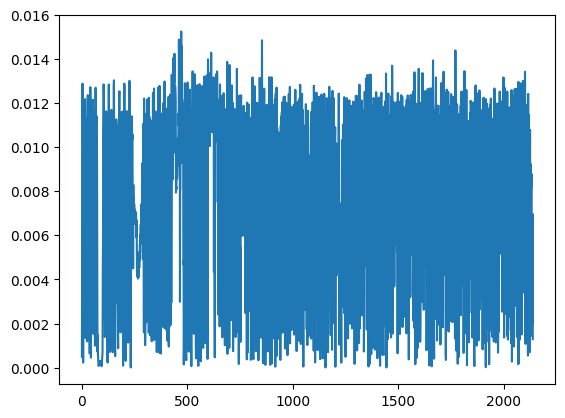

In [21]:
from geometry.param_curve import phi, psi
import sympy as sp
X_perturbed = sp.Matrix([
    (1 + 0.4*sp.cos(phi)) * sp.cos(psi) + a*sp.sin(6*psi)*sp.cos(psi)*sp.cos(phi),
    (1 + 0.4*sp.cos(phi)) * sp.sin(psi) + a*sp.sin(6*psi)*sp.sin(psi)*sp.cos(phi),
    0.4*sp.sin(phi) + a*sp.sin(6*psi)*sp.sin(phi)
])

obj = ParamSurface(X_perturbed,num_points=400000)

phi_values, psi_values, points, tol_info = obj.proj_param(Vertices_Coords,tol=1e-8,max_iter=10)

import matplotlib.pyplot as plt
plt.plot(np.linalg.norm(points - Vertices_Coords, axis = 1))

In [22]:
disp = points - Vertices_Coords

In [23]:
DB_BGN_Obj.Disp.vec.data = BaseVector(tmpv + disp.flatten("F"))

In [24]:
DB_BGN_Obj.mesh.SetDeformation(DB_BGN_Obj.Disp)

In [25]:
Draw(x, DB_BGN_Obj.mesh, 'disp')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [31]:
order = 1
mesh_name = "../../../data/order_{}_beads.vol".format(order)
DB_BGN_Obj.mesh.ngmesh.Save (mesh_name)
print(mesh_name)

np.savez("../../../data/order_{}_deformation_beads.npz".format(order), 
         deform=DB_BGN_Obj.Disp.vec.FV().NumPy())

../../../data/order_1_beads.vol


### 如何得到二次的deformation

In [32]:
from es_utils import pos_transformer, SurfacehInterp

In [33]:
order = 2
mesh = DB_BGN_Obj.mesh
fesir = IntegrationRuleSpaceSurface(mesh, order=order, definedon=mesh.Boundaries('.*'))
irs = fesir.GetIntegrationRules()

In [34]:
mesh.UnsetDeformation()
interp_obj = SurfacehInterp(mesh,order)
init_coords_3d = interp_obj.get_coords_quad() # 通过Interpolation

In [35]:
mesh.SetDeformation(DB_BGN_Obj.Disp)
interp_obj = SurfacehInterp(mesh,order)
coords_3d = interp_obj.get_coords_quad() # 通过Interpolation
Disp0 = GridFunction(DB_BGN_Obj.fesV)
get_gfu = lambda x: interp_obj.return_l2(x,deform=DB_BGN_Obj.Disp) # 固定deform，防止曲面变化

In [36]:
phi_values, psi_values, points, tol_info = obj.proj_param(coords_3d,tol=1e-8,max_iter=10)

In [37]:
fesV2 = VectorH1(mesh,order=order)
init_deformation = GridFunction(fesV2)
# 将Interpolation的位置点投影到精确曲面上
def_coords = points - init_coords_3d
deformx, deformy, deformz = map(get_gfu,[def_coords[:,0],def_coords[:,1],def_coords[:,2]])
deform_xyz = np.concatenate([deformx, deformy, deformz])
init_deformation.vec.data = BaseVector(deform_xyz)
mesh.SetDeformation(init_deformation)

In [38]:
Draw(Norm(Trace(specialcf.Weingarten(3))),mesh,"vv")
# Draw(x,mesh,"vv")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [39]:
mesh.ngmesh.Save ("../../../data/order_{}_mesh_beads.vol".format(order))

np.savez("../../../data/order_{}_deformation_beads.npz".format(order), deform=init_deformation.vec.FV().NumPy())